# 서울 부동산 시장 분석 및 투자 전략 수립

## 자유주제: 금리 가 서울 부동산 시장에 미치는 영향 분석
1. 금리 데이터 크롤링
    - 금리 데이터와 부동산 시장(거래량, 거래금액)과의 상관관계/선행관계 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약월'] = pd.to_datetime(df_sales['계약일'], format='%Y%m%d')


In [2]:
df_interest = pd.read_csv('./data_raw/금리.csv')
df_interest['월'] = pd.to_datetime(df_interest['월'], format='%Y-%m')

from da_utils.calc_monthly_annual import calc_monthly_annual
monthly_stats, _ = calc_monthly_annual(df_sales)

# 월별 거래량, 평단가 변화율 계산
monthly_stats['월별거래량변화율'] = monthly_stats['월별거래건수'].pct_change()
monthly_stats['월별평단가변화율'] = monthly_stats['월평균평단가'].pct_change()

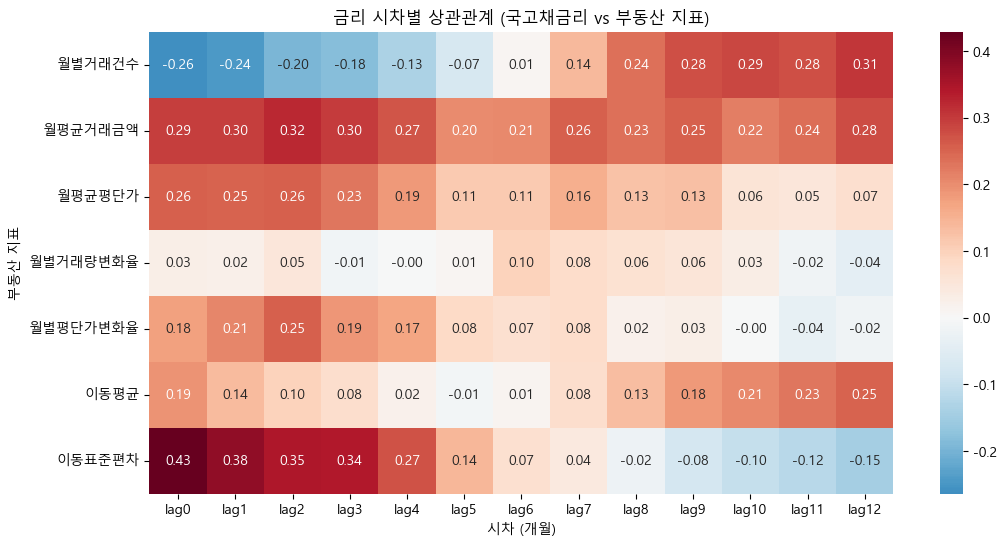

In [32]:
# 1. 컬럼명 통일 후 merge
df_interest = df_interest.rename(columns={'월': '계약월'})
df = pd.merge(monthly_stats, df_interest, on='계약월', how='inner')

# 2. 분석 대상 변수
target_vars = ['월별거래건수','월평균거래금액','월평균평단가',
               '월별거래량변화율','월별평단가변화율','이동평균','이동표준편차']

# 3. 시차 적용 후 상관계수 저장
max_lag = 12
corr_dict = {}

for lag in range(max_lag+1):
    df[f'금리_lag{lag}'] = df['국고채5년(평균)'].shift(lag)
    corr_values = []
    for col in target_vars:
        corr = df[[col, f'금리_lag{lag}']].corr().iloc[0,1]
        corr_values.append(corr)
    corr_dict[f'lag{lag}'] = corr_values

# 4. 데이터프레임 변환
corr_df = pd.DataFrame(corr_dict, index=target_vars)

# 5. 히트맵 시각화
plt.figure(figsize=(12,6))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0
)
plt.title("금리 시차별 상관관계 (국고채금리 vs 부동산 지표)")
plt.xlabel("시차 (개월)")
plt.ylabel("부동산 지표")
plt.savefig('./fig/04-1_interest_correlation/금리시차별상관관계히트맵.png', dpi=300, bbox_inches='tight')
plt.show()

이동표준편차 = 변동성, 금리와 가장 높은 상관관계를 보임 - 금리가 높아질수록 변동성이 높아진다 ==> 금리가 올라가면 집값이 요동친다

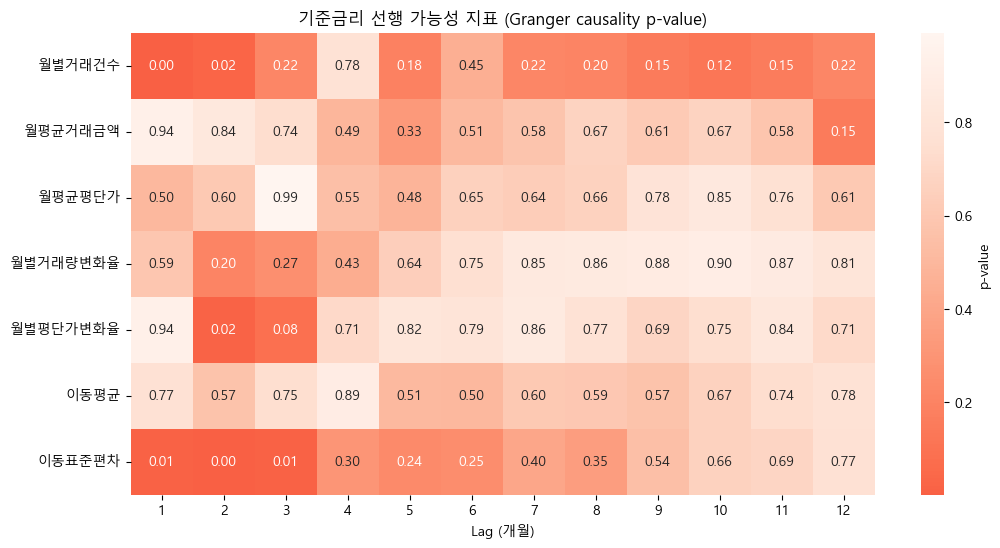

In [28]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# 대상 변수
target_vars = ['월별거래건수','월평균거래금액','월평균평단가',
               '월별거래량변화율','월별평단가변화율','이동평균','이동표준편차']

# 결과를 담을 데이터프레임 초기화
max_lag = 12
granger_results = pd.DataFrame(index=range(1, max_lag+1), columns=target_vars)

# 각 변수에 대해 Granger causality 테스트
for var in target_vars:
    for lag in range(1, max_lag+1):
        # NaN 제거 후 테스트
        test_df = df[[var, '기준금리']].dropna()
        try:
            test_result = grangercausalitytests(test_df[['기준금리', var]], maxlag=lag, verbose=False)
            p_value = test_result[lag][0]['ssr_ftest'][1]  # F-test p-value
        except:
            p_value = None
        granger_results.loc[lag, var] = p_value

# p-value 보기 좋게 float로 변환
granger_results = granger_results.astype(float)
# display(granger_results)

df_pval = pd.DataFrame(granger_results, index=range(1, max_lag+1))

# 시각화
plt.figure(figsize=(12,6))
sns.heatmap(df_pval.T, annot=True, fmt=".2f", cmap="Reds_r", cbar_kws={'label': 'p-value'}, center=0.05)
plt.title('기준금리 선행 가능성 지표 (Granger causality p-value)')
plt.xlabel('Lag (개월)')
plt.savefig('./fig/04-1_interest_correlation/기준금리선행가능성지표.png', dpi=300, bbox_inches='tight')
plt.show()
